# btlflt.ipynb

There is much interest in using insect wimgbeat waveforms for automated monitoring of insect flight activity. [Perform a Google search for "insect wingbeat waveform"](https://www.google.com/search?client=ubuntu&channel=fs&q=insect+wingbeat+harmonics#vhid=RcBJqwjT8KH1GM&vssid=l) to see what I mean. 

Wingbeat waveforms can be recorded acoustically using a microphone, or optically using a photosensor. 

Here is the waveform and frequency spectrum of a mosquito I recorded way back in 1984 using a photodiode:

<img src="../images/example_waveform.png" width = "500px">

From [Moore, A. 1991. Artificial neural network trained to identify mosquitoes in flight.](https://www.researchgate.net/publication/226904676_Artificial_neural_network_trained_to_identify_mosquitoes_in_flight)

As you can see, spectral analysis of an insect wingbeat waveforms reveals that it contains a harmonic series consisting of the wingbeat frequency plus harmonics occurring at integer multiples of the wingbeat frequency.

I suggested that automated instrumentation could be developed to identify species of flying insects by recognizing spectral patterns formed by harmonics in much the same way in which the human brain and ear identifies musical instruments by recognizing distinct harmonic patterns in the sounds they produce (Moore, A. 1986).

Ever since doing this research 40 years ago, I have wondered about the origin of harmonics in optically recorded insect wingbeat waveforms. Here is an unpublished chart I made to help figure this out:

<img src="../images/waveform_chart.png">

1. Changes in reflective area of the insect during the wingbeat cycle. For example, occlusion of the wings by the thorax and abdomen.
2. Specular reflections from shiny parts of the insect such as wing membranes.
3. Phantom harmonics which are an artifact of the Fast Fourier Transform. 

In [1]:
import btlflt as bf

In [2]:
# Note: .gitignore includes VIDEOPATH and FRAMESDIR

VIDEO_PATH = 'video.mp4' # path to video file of beetles in flight downloaded from YouTube
FRAMES_DIR = 'frames'    # directory containing all frames extracted from VIDEO_PATH

# Parameters for scene being analyzed

SCENE_ID = 'F1-718'  # identifier for scene being analyzed
FIRST_FRAME_NUM = 1  # first frame number in scene 
LAST_FRAME_NUM = 718 # last frame number in scene
SAMPLE_RATE = 6000   # Original sample rate for the scene in frames per second
THRESH = 152         # threshold value for bf.remove_background

# Relative paths of results for the scene being analyzed. 
# Parent directory is the directory containing this script (beetles_in_flight/code).

SCENE_IMAGES_DIR = f'{SCENE_ID}/images' # directory containing grayscale images of the scene
SCENE_VIDEO = f'{SCENE_ID}/video.mp4'   # path to video file of the scene

FIGURES_DIR = f'{SCENE_ID}/fi_figs'       # frame intensity figures generated by bf.create_frame_intensity_figure
FIGURES_VIDEO = f'{SCENE_ID}/fi_figs.mp4' # path to video file of figures generated by bf.create_frame_intensity_figure

FG_MASKS_DIR = f'{SCENE_ID}/fg_masks'         # foreground masks generated by bf.remove_background
FG_MASKS_VIDEO = f'{SCENE_ID}/fg_masks.mp4'   # path to video file of foreground masks generated by bf.remove_background
FG_IMAGES_DIR = f'{SCENE_ID}/fg_images'       # foreground images generated by bf.remove_background
FG_IMAGES_VIDEO = f'{SCENE_ID}/fg_images.mp4' # path to video file of foreground images generated by bf.remove_background

# MAIN PROGRAM

In [3]:
# Step 1: Download the YouTube video (best quality, no audio)

if bf.os.path.exists(VIDEO_PATH):
    print(f'VIDEO_PATH ({VIDEO_PATH}) already exists')
else:
    command = f'yt-dlp -o {VIDEO_PATH} -f bestvideo https://www.youtube.com/watch?v=IUQSZHr9h9Q'
    bf.os.system(command)

VIDEO_PATH (video.mp4) already exists


In [4]:
# Step 2: Extract frames from the video

bf.video2frames(VIDEO_PATH, FRAMES_DIR)

Images directory frames already exists. Skipping video2frames conversion.


In [5]:
# Step 2a: Extract grayscale images for the scene and save in SCENE_IMAGES_DIR

if bf.os.path.exists(SCENE_IMAGES_DIR):
    print(f'SCENE_IMAGES_DIR ({SCENE_IMAGES_DIR}) already exists. Skipping.')
else:
    bf.os.makedirs(SCENE_IMAGES_DIR, exist_ok=True)
    for i in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):  
        bf.create_grayscale_image(f'{FRAMES_DIR}/{i:04d}.png', f'{SCENE_IMAGES_DIR}/{i:04d}.png')

SCENE_IMAGES_DIR (F1-718/images) already exists. Skipping.


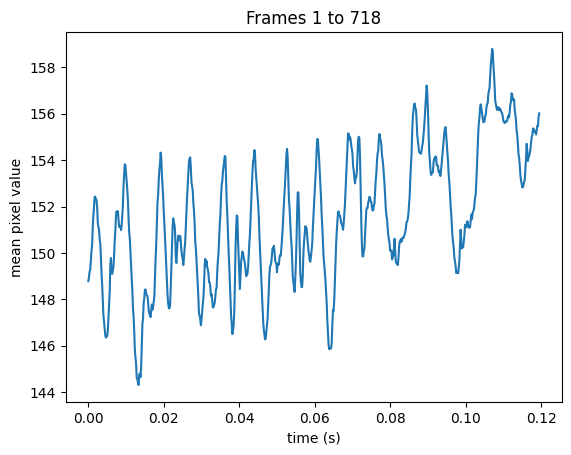

In [7]:
# Step 3: Calculate time and light intensity for each frame

# create seconds_list which will be used for the x axis
seconds_list = [i/SAMPLE_RATE for i in range(1 + LAST_FRAME_NUM - FIRST_FRAME_NUM)]

# create intensity_list which will be used for the y axis
mean_pixel_values = bf.calc_intensity_time_series(SCENE_IMAGES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)

# plot results
bf.plt.plot(seconds_list, mean_pixel_values)
bf.plt.title(f"Frames {FIRST_FRAME_NUM} to {LAST_FRAME_NUM}")
bf.plt.xlabel("time (s)")
bf.plt.ylabel("mean pixel value")

# Create WAV file, save it and provide an audio player
# We normalize the signal so that it ranges between -1 and 1
intensity_list = bf.calc_intensity_time_series(SCENE_IMAGES_DIR, FIRST_FRAME_NUM, LAST_FRAME_NUM)
bf.create_wav_file(filename='intensity_timeseries.wav', data=intensity_list, framerate=SAMPLE_RATE)
bf.Audio('intensity_timeseries.wav')

<audio src='intensity_timeseries.wav'></audio>

In [12]:
# Step 4: Make figures to visualize the relationship between an image sequence and the wingbeat waveform

# Create a video from the frames
if bf.os.path.exists(FIGURES_DIR):
    print(f'FIGURES_DIR ({FIGURES_DIR}) already exists. Skipping.')
else:
    bf.os.makedirs(FIGURES_DIR)
    for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
        bf.create_frame_intensity_figure(
            frame_num,
            seconds_list, 
            intensity_list, 
            frame_path = f'{FRAMES_DIR}/{frame_num:04d}.png', 
            fig_path = f'{FIGURES_DIR}/{frame_num:04d}.png'
        )

FIGURES_DIR (F1-718/fi_figs) already exists. Skipping.


In [7]:
# Step 5: Create a video from the figures

bf.frames2video(FIGURES_DIR, FIGURES_VIDEO)

# Provide a video player
bf.Video(FIGURES_VIDEO)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [8]:
# Step 6: Estimate the harmonic frequencies

# Signal conditioning

# Apply Butterworth bandpass filter to suppress frequencies below 30 Hz and greater than 2000 Hz.
filtered_data = bf.butter_bandpass_filter(data=intensity_list, lowcut=30, highcut=2000, fs=SAMPLE_RATE, order=6)
# Apply a Hanning window to taper the amplitude to zero at both ends.
windowed_filtered_data = bf.np.hanning(len(filtered_data)) * filtered_data

# Estimate the wingbeat frequency from the conditioned signal
wbf = bf.freq_from_autocorr(windowed_filtered_data, SAMPLE_RATE)

# Calculate the first 10 harmonic frequencies
harmonic_frequencies = [i * wbf for i in range(1, 11)]
for i in range(10):
    print(f'f{i}: {harmonic_frequencies[i]:.1f} Hz')  

f0: 59.9 Hz
f1: 119.9 Hz
f2: 179.8 Hz
f3: 239.8 Hz
f4: 299.7 Hz
f5: 359.7 Hz
f6: 419.6 Hz
f7: 479.6 Hz
f8: 539.5 Hz
f9: 599.5 Hz


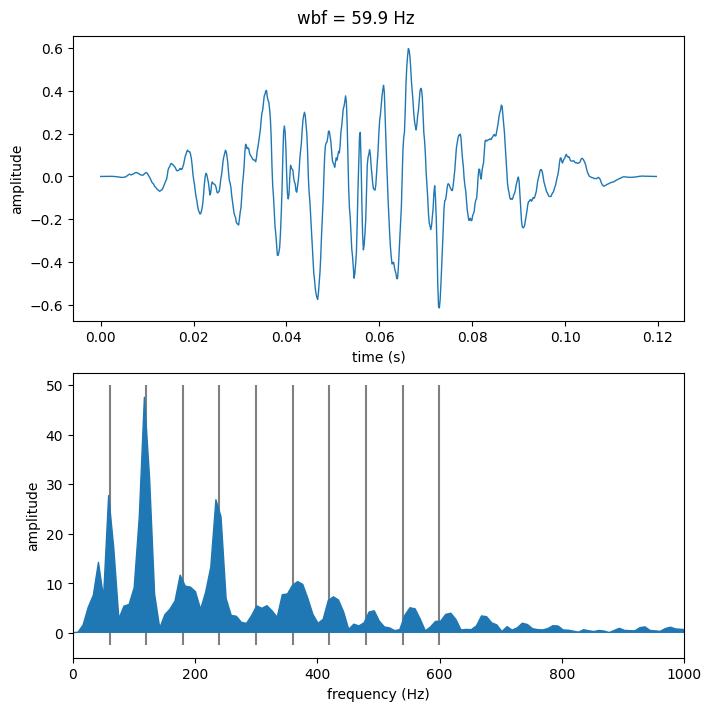

In [9]:
# Step 7: Perform a Fourier transform to estimate the frequency spectrum

# Plot the conditioned signal
fig, (axt, axf) = bf.plot_time_frequency(SAMPLE_RATE, windowed_filtered_data)

# Modify the figure to show the first 10 harmonic frequencies

# Limit the frequency range to 1000 Hz
axf.set_xlim(0, 1000)
# Set the zorder of the harmonic frequency lines to 0 so that the will be behind the spectrogram (zorder=1)
axf.set_zorder(1)
ymin, ymax = axf.get_ylim()
axf.vlines(x=harmonic_frequencies, ymin=ymin, ymax=ymax, color='gray', zorder=0)
# Display the wingbeat frequency in the title
fig.suptitle(f'wbf = {wbf:.1f} Hz')
fig

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='windowed_filtered_data.wav', data=windowed_filtered_data, framerate=SAMPLE_RATE)
bf.Audio('windowed_filtered_data.wav')

In [10]:
# Step 8: Create foreground masks and masked images

if bf.os.path.exists(FG_MASKS_DIR):
    print(f'FG_MASKS_DIR ({FG_MASKS_DIR}) already exists. Skipping.')
else:
    bf.os.makedirs(FG_MASKS_DIR)
    bf.os.makedirs(FG_IMAGES_DIR)
    
    for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
        bf.remove_background(
            input_image_path=f'{FRAMES_DIR}/{frame_num:04d}.png', 
            output_image_path=f'{FG_IMAGES_DIR}/{frame_num:04d}.png',
            mask_path=f'{FG_MASKS_DIR}/{frame_num:04d}.png',
            thresh=THRESH
        )

In [16]:
# Step 9: Create videos of masks and masked images

bf.frames2video(FG_MASKS_DIR, FG_MASKS_VIDEO)
bf.frames2video(FG_IMAGES_DIR, FG_IMAGES_VIDEO)

Video file F1-718/fg_masks.mp4 already exists. Skipping frames2video conversion.
Video file F1-718/fg_images.mp4 already exists. Skipping frames2video conversion.


In [12]:
# Provide a player for FG_MASKS_VIDEO
bf.Video(FG_MASKS_VIDEO, width=400)

In [13]:
# Provide a player for FG_IMAGES_VIDEO
bf.Video(FG_IMAGES_VIDEO, width=400)

### Finished

### Fine tuning the threshold for background removal

1. Run bf.remove_background with a low thesh parameter, 100 for example.
2. Scan through the resulting mask images and find one which parts of the insect appear to be missing. Record the frame number.
3. Create masks and masked images for this single frame number with varying thresholds from 100 to 255.
4. Scan through the resulting masks or images to select an optimum value for THRESH.

TODO: Make a tool to do this stuff, possibly a separate notebook using interactive widgets.

In [15]:
# Create masks and masked images for a single frame with varying thresholds for background removal

frame_num = 189
bf.os.makedirs('temp/images')
bf.os.makedirs('temp/masks')
for thresh in range(0, 256):
    bf.remove_background(
        input_image_path='frames/0189.png',
        output_image_path=f'temp/images/0189_{thresh:03d}.png',
        mask_path=f'temp/masks/0189_{thresh:03d}.png',
        thresh=thresh)

In [23]:
# FFT to detect frequency components of background pixels

# Concatenate foreground masks into a single mask 

# Create a max for pixels which are in the background for the entire 

for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
    fg_mask = bf.cv2.imread(f'{FG_MASKS_DIR}/{frame_num:04d}.png', bf.cv2.IMREAD_GRAYSCALE)
    if frame_num == FIRST_FRAME_NUM:
        flightpath_mask = fg_mask
    else:
        flightpath_mask = bf.np.maximum(fg_mask, flightpath_mask)

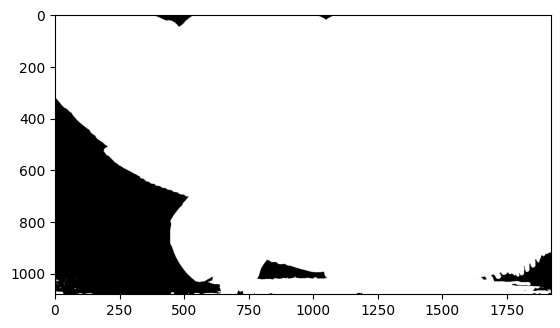

In [24]:
bf.plt.imshow(flightpath_mask, cmap='gray');

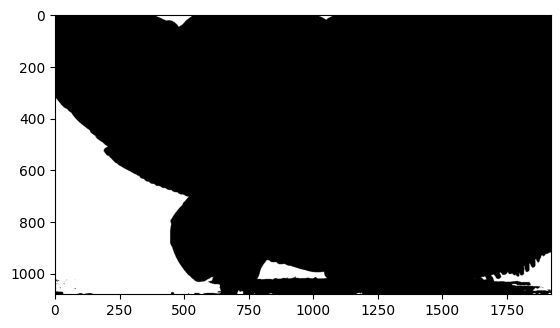

In [25]:
background_mask = bf.cv2.bitwise_not(flightpath_mask)
bf.plt.imshow(background_mask, cmap='gray');

In [26]:
bf.os.makedirs('temp/bg_images', exist_ok=True)
for frame_num in range(FIRST_FRAME_NUM, LAST_FRAME_NUM + 1):
    img = bf.cv2.imread(f'{SCENE_IMAGES_DIR}/{frame_num:04d}.png', bf.cv2.IMREAD_GRAYSCALE)
    img = bf.cv2.bitwise_and(img, img, mask=background_mask)
    bf.cv2.imwrite(f'temp/bg_images/{frame_num:04d}.png', img)

In [27]:
bf.frames2video('temp/bg_images', 'temp/bg_images.mp4')

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

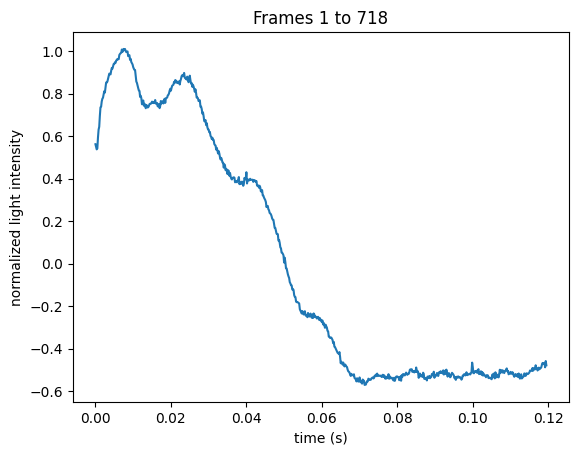

In [28]:
# Calculate time and light intensity for each frame

# create seconds_list which will be used for the x axis
seconds_list = [i/SAMPLE_RATE for i in range(1 + LAST_FRAME_NUM - FIRST_FRAME_NUM)]

# create intensity_list which will be used for the y axis
intensity_list = bf.calc_intensity_time_series('temp/bg_images', FIRST_FRAME_NUM, LAST_FRAME_NUM)

# plot results
bf.plt.plot(seconds_list, intensity_list)
bf.plt.title(f"Frames {FIRST_FRAME_NUM} to {LAST_FRAME_NUM}")
bf.plt.xlabel("time (s)")
bf.plt.ylabel("normalized light intensity")

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='intensity_timeseries.wav', data=intensity_list, framerate=SAMPLE_RATE)
bf.Audio('intensity_timeseries.wav')    


In [29]:
# Step 6: Estimate the harmonic frequencies

# Signal conditioning

# Apply Butterworth bandpass filter to suppress frequencies below 30 Hz and greater than 2000 Hz.
filtered_data = bf.butter_bandpass_filter(data=intensity_list, lowcut=30, highcut=2000, fs=SAMPLE_RATE, order=6)
# Apply a Hanning window to taper the amplitude to zero at both ends.
windowed_filtered_data = bf.np.hanning(len(filtered_data)) * filtered_data

# Estimate the wingbeat frequency from the conditioned signal
wbf = bf.freq_from_autocorr(windowed_filtered_data, SAMPLE_RATE)

# Calculate the first 10 harmonic frequencies
harmonic_frequencies = [i * wbf for i in range(1, 11)]
for i in range(10):
    print(f'f{i}: {harmonic_frequencies[i]:.1f} Hz')  

f0: 27.3 Hz
f1: 54.6 Hz
f2: 81.9 Hz
f3: 109.2 Hz
f4: 136.5 Hz
f5: 163.8 Hz
f6: 191.2 Hz
f7: 218.5 Hz
f8: 245.8 Hz
f9: 273.1 Hz


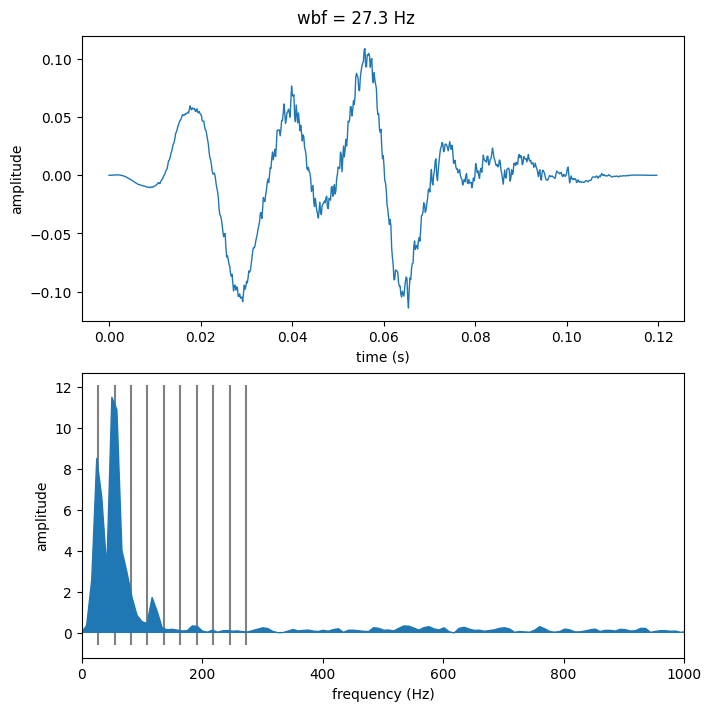

In [32]:
# Step 7: Perform a Fourier transform to estimate the frequency spectrum

# Plot the conditioned signal
fig, (axt, axf) = bf.plot_time_frequency(SAMPLE_RATE, windowed_filtered_data)

# Modify the figure to show the first 10 harmonic frequencies

# Limit the frequency range to 1000 Hz
axf.set_xlim(0, 1000)
# Set the zorder of the harmonic frequency lines to 0 so that the will be behind the spectrogram (zorder=1)
axf.set_zorder(1)
ymin, ymax = axf.get_ylim()
axf.vlines(x=harmonic_frequencies, ymin=ymin, ymax=ymax, color='gray', zorder=0)
# Display the wingbeat frequency in the title
fig.suptitle(f'wbf = {wbf:.1f} Hz')
fig

# Create WAV file, save it and provide an audio player
bf.create_wav_file(filename='background_windowed_filtered_data.wav', data=windowed_filtered_data, framerate=SAMPLE_RATE)
bf.Audio('background_windowed_filtered_data.wav', rate=6000)